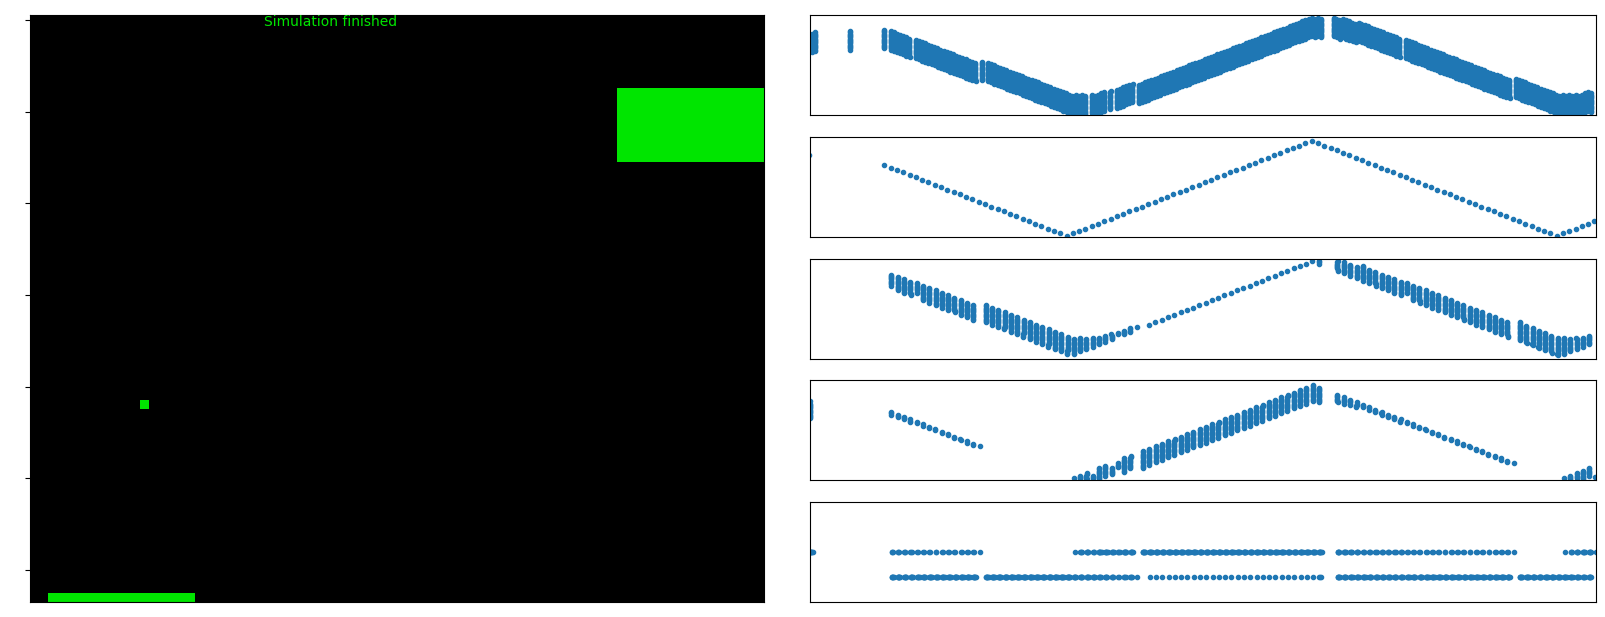

2022-05-03 10:22:27 INFO: Receive callback functools.partial(<function handle_vis_spikes at 0x7f9eec3e0d30>, vis=<spinn_gym.games.breakout.visualiser.visualiser.Visualiser object at 0x7f9ee3f5fd90>) registered to label breakout1
2022-05-03 10:22:27 INFO: Receive callback functools.partial(<function handle_live_spikes at 0x7f9eec3e0dc0>, vis=<spinn_gym.games.breakout.visualiser.visualiser.Visualiser object at 0x7f9ee3f5fd90>) registered to label paddle_pop
2022-05-03 10:22:27 INFO: Receive callback functools.partial(<function handle_live_spikes at 0x7f9eec3e0dc0>, vis=<spinn_gym.games.breakout.visualiser.visualiser.Visualiser object at 0x7f9ee3f5fd90>) registered to label ball_pop
2022-05-03 10:22:27 INFO: Receive callback functools.partial(<function handle_live_spikes at 0x7f9eec3e0dc0>, vis=<spinn_gym.games.breakout.visualiser.visualiser.Visualiser object at 0x7f9ee3f5fd90>) registered to label left_hidden_pop
2022-05-03 10:22:27 INFO: Receive callback functools.partial(<function hand

In [1]:
import spynnaker8 as p
from spinn_gym.games.breakout.visualise_jupyter import jupyter_visualiser
from spinn_gym.games.breakout.automated_breakout import (
    AutomatedBreakout, X_RES, X_SCALE, Y_RES, Y_SCALE)

# ----------------------------------------------------------------------------------------------------------------------
# Initialise Simulation and Parameters
# ----------------------------------------------------------------------------------------------------------------------
breakout = AutomatedBreakout()

# ----------------------------------------------------------------------------------------------------------------------
# Configure Visualiser
# ----------------------------------------------------------------------------------------------------------------------
jupyter_visualiser(breakout, X_RES, X_SCALE, Y_RES, Y_SCALE, 
                   [breakout.paddle_pop, breakout.ball_pop, 
                    breakout.left_hidden_pop, breakout.right_hidden_pop, breakout.decision_input_pop])

In [2]:
# ----------------------------------------------------------------------------------------------------------------------
# Run Simulation
# ----------------------------------------------------------------------------------------------------------------------
runtime = 1000 * 120
print("\nLet\'s play breakout!")
p.run(runtime)
p.end()
print("Simulation Complete")

2022-05-03 10:22:27 WARNING: File spynnaker8 moved to pyNN.spinnaker which points to spynnaker.pyNN. Please fix your imports. In version 8 this will fail completely.
2022-05-03 10:22:27 INFO: Starting execution process
2022-05-03 10:22:27 INFO: Simulating for 120000 1.0ms timesteps using a hardware timestep of 1000.0us



Let's play breakout!


2022-05-03 10:22:30 INFO: Spalloc max machine generator took 0:00:03.013454 
2022-05-03 10:22:30 INFO: SpYNNakerNeuronGraphNetworkSpecificationReport skipped as cfg Reports:write_network_graph is False
2022-05-03 10:22:30 INFO: Network Specification report took 0:00:00.000609 
2022-05-03 10:22:30 INFO: Splitter reset took 0:00:00.000015 
Adding Splitter selectors where appropriate
|0%                          50%                         100%|
2022-05-03 10:22:30 INFO: Spynnaker splitter selector took 0:00:00.011239 
2022-05-03 10:22:30 INFO: Preallocate for live packet gatherer took 0:00:00.000062 
2022-05-03 10:22:30 INFO: Preallocate for chip power monitor skipped as cfg Reports:write_energy_report is False
2022-05-03 10:22:30 INFO: Preallocate for extra monitor support took 0:00:00.000076 
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
 ========/home/bb

ValueError: shape mismatch: objects cannot be broadcast to a single shape

ValueError: shape mismatch: objects cannot be broadcast to a single shape

ValueError: shape mismatch: objects cannot be broadcast to a single shape

ValueError: shape mismatch: objects cannot be broadcast to a single shape

ValueError: shape mismatch: objects cannot be broadcast to a single shape

ValueError: shape mismatch: objects cannot be broadcast to a single shape

ValueError: shape mismatch: objects cannot be broadcast to a single shape

ValueError: shape mismatch: objects cannot be broadcast to a single shape

ValueError: shape mismatch: objects cannot be broadcast to a single shape

ValueError: shape mismatch: objects cannot be broadcast to a single shape

ValueError: shape mismatch: objects cannot be broadcast to a single shape

Packet contains invalid pixels: [   35 16381 16637 16893 17149 17405 17661 17917 18173 18429 18685 18941
 19197 19453 19709 19965 20221 20476 20216 20721] X: [ 0 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 78 80]   Y: [ 8 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 62 60]  c: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1]  b: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] index 80 is out of bounds for axis 1 with size 80
Packet contains invalid pixels: [   35 20720 20201] X: [ 0 80 78]   Y: [ 8 60 58]  c: [1 0 1]  b: [1 0 0] index 80 is out of bounds for axis 1 with size 80


ValueError: shape mismatch: objects cannot be broadcast to a single shape

ValueError: shape mismatch: objects cannot be broadcast to a single shape

2022-05-03 10:25:19 INFO: ** Sending pause / stop message to external sources to state the simulation has been paused or stopped. **
2022-05-03 10:25:19 WARNING: *** Failed to send stop/pause notification to external application on 127.0.0.1:19999 about the simulation ***
Traceback (most recent call last):
  File "/home/bbpnrsoa/sPyNNakerGit/SpiNNMan/spinnman/connections/udp_packet_connections/udp_connection.py", line 208, in send
    while not self._socket.send(data):
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/bbpnrsoa/sPyNNakerGit/SpiNNFrontEndCommon/spinn_front_end_common/utilities/notification_protocol/notification_protocol.py", line 110, in send_stop_pause_notification
    c.send_eieio_message(eieio_command_message)
  File "/home/bbpnrsoa/sPyNNakerGit/SpiNNMan/spinnman/connections/udp_packet_connections/eieio_connection.py", line 45, in send_eieio_mes

Visualiser closed



2022-05-03 10:25:20 INFO: Buffer extractor took 0:00:01.015651 
clearing IOBUF from the machine
|0%                          50%                         100%|
2022-05-03 10:25:20 INFO: Clear IO buffer took 0:00:00.017272 
Getting provenance data from machine graph
|0%                          50%                         100%|
Getting provenance data from application graph
|0%                          50%                         100%|
2022-05-03 10:25:20 INFO: Graph provenance gatherer took 0:00:00.112618 
Getting provenance data
|0%                          50%                         100%|
2022-05-03 10:25:21 INFO: Placements provenance gatherer took 0:00:00.289765 
Getting Router Provenance
|0%                          50%                         100%|
 ==2022-05-03 10:25:21 WARNING: The router on 4, 4 has dropped 2 multicast packets that were transmitted by local cores. This occurs where the router has no entry associated with the multicast key. Try investigating the keys allocated

Simulation Complete
